### 统计生命周期信息
绘制生命周期时间线图、内存访问图（以时间为X轴，内存地址空间为Y轴），计算实际活跃率

#### 1. 读取、预处理数据

In [81]:
results_dir = "results"

In [82]:
import pandas as pd
from sqlalchemy import create_engine

# 使用SQLAlchemy连接
engine = create_engine('sqlite:///data/matrixmultiplication/1_save_memory_c=a.sqlite3')  # 注意路径格式：sqlite:///
df = pd.read_sql_table('trace', engine)
print(df.columns)
print(df.head())

Index(['ID', 'ParentID', 'Kind', 'What', 'Location', 'StartTime', 'EndTime',
       'DeviceID', 'PID', 'Address', 'ByteSize'],
      dtype='object')
                     ID       ParentID     Kind  \
0         19162_req_out   19162@Driver  req_out   
1         17357_req_out          17357  req_out   
2         19163_req_out          19163  req_out   
3  19954@GPU[1].DRAM[0]  19954_req_out   req_in   
4  19955@GPU[1].DRAM[0]  19955_req_out   req_in   

                              What                 Location  StartTime  \
0                 *mem.AllocateReq                   Driver   0.000015   
1  *protocol.MemoryAllocateTrigger  GPU[1].CommandProcessor   0.000015   
2      *protocol.MemoryAllocateRsp                   Driver   0.000015   
3                    *mem.WriteReq           GPU[1].DRAM[0]   0.000016   
4                    *mem.WriteReq           GPU[1].DRAM[0]   0.000016   

    EndTime  DeviceID  PID     Address  ByteSize  
0  0.000015         1    1  4294971392     16384

In [83]:
# 向量化计算页范围
df['StartPage'] = df['Address'] // 4096
df['EndPage'] = (df['Address'] + df['ByteSize'] - 1) // 4096

# 筛选出内存相关的请求
mem_df = df[ df['What'].isin(['*mem.AllocateReq', '*mem.FreeReq']) | 
                df['What'].isin(['*mem.ReadReq', '*mem.WriteReq']) & 
                    ((df['Location'].str.contains('DRAM', na=False)) 
                    #  | (df['Location'].str.contains('L1', na=False)) 
                    #  | (df['Location'].str.contains('L2', na=False)) 
                    #  | (df['Location'].str.contains('DMA', na=False)) 
                    #  | (df['Kind'].str.contains('req_out') & (df['Location'].str.contains('AddrTrans', na=False)))
                    )
            ]

# print(mem_df[mem_df['What'].isin(['*mem.FreeReq'])])

# 生成所有页的访问记录
rows = []
for _, row in mem_df.iterrows():
    for page in range(row['StartPage'], row['EndPage'] + 1):
        rows.append({
            'DeviceID': row['DeviceID'],
            # 'PID': row['PID'],
            'PageID': page,
            'AccessType': row['What'],
            'StartTime': row['StartTime'],
            'EndTime': row['EndTime'],
        })

page_access_df = pd.DataFrame(rows)
print(page_access_df)
# print(page_access_df[page_access_df['AccessType'].isin(['*mem.FreeReq'])])


      DeviceID   PageID        AccessType  StartTime   EndTime
0            1  1048577  *mem.AllocateReq   0.000015  0.000015
1            1  1048578  *mem.AllocateReq   0.000015  0.000015
2            1  1048579  *mem.AllocateReq   0.000015  0.000015
3            1  1048580  *mem.AllocateReq   0.000015  0.000015
4            0  1048577     *mem.WriteReq   0.000016  0.000016
...        ...      ...               ...        ...       ...
1487         0  1048580      *mem.ReadReq   0.000112  0.000112
1488         1  1048577      *mem.FreeReq   0.000112  0.000112
1489         1  1048578      *mem.FreeReq   0.000112  0.000112
1490         1  1048579      *mem.FreeReq   0.000112  0.000112
1491         1  1048580      *mem.FreeReq   0.000112  0.000112

[1492 rows x 5 columns]


#### 2. 处理内存访问数据

In [84]:
# 按 PageID 分组，计算各页面的关键时间指标
rw_df = page_access_df[page_access_df['AccessType'].isin(['*mem.ReadReq', '*mem.WriteReq'])]
print(rw_df)

page_rw_stats_df = rw_df.groupby('PageID').agg({
    'StartTime': ['min'],
    "EndTime": ['max'],
    'AccessType': lambda x: list(x.unique())  # 记录所有操作类型
}).reset_index()
page_rw_stats_df.columns = ['PageID', 'FirstAccessTime', 'LastAccessTime', 'AccessTypes']

# 添加生命周期持续时间列
page_rw_stats_df['ActualLifeDuration'] = page_rw_stats_df['LastAccessTime'] - page_rw_stats_df['FirstAccessTime']

print(page_rw_stats_df)

      DeviceID   PageID     AccessType  StartTime   EndTime
4            0  1048577  *mem.WriteReq   0.000016  0.000016
5            0  1048577  *mem.WriteReq   0.000016  0.000016
6            0  1048577  *mem.WriteReq   0.000016  0.000016
7            0  1048577  *mem.WriteReq   0.000016  0.000016
8            0  1048577  *mem.WriteReq   0.000016  0.000016
...        ...      ...            ...        ...       ...
1483         0  1048580   *mem.ReadReq   0.000112  0.000112
1484         0  1048580   *mem.ReadReq   0.000112  0.000112
1485         0  1048580   *mem.ReadReq   0.000112  0.000112
1486         0  1048580   *mem.ReadReq   0.000112  0.000112
1487         0  1048580   *mem.ReadReq   0.000112  0.000112

[1470 rows x 5 columns]
     PageID  FirstAccessTime  LastAccessTime                    AccessTypes  \
0   1048577         0.000016        0.000111  [*mem.WriteReq, *mem.ReadReq]   
1   1048578         0.000016        0.000112  [*mem.WriteReq, *mem.ReadReq]   
2   1048579       

#### 3. 处理内存分配/释放数据

In [85]:
# 筛选分配和释放请求
af_df = page_access_df[page_access_df['AccessType'].isin(['*mem.AllocateReq', '*mem.FreeReq'])]

# 提取分配时间（每个 PageID 的最小 StartTime）
alloc_df = af_df[af_df['AccessType'] == '*mem.AllocateReq'].groupby('PageID')['StartTime'].min().reset_index()
alloc_df.columns = ['PageID', 'AllocateTime']

# 提取释放时间（每个 PageID 的最大 StartTime）
free_df = af_df[af_df['AccessType'] == '*mem.FreeReq'].groupby('PageID')['StartTime'].max().reset_index()
free_df.columns = ['PageID', 'FreeTime']

# 合并分配、释放和读写统计
page_af_stats_df = pd.merge(alloc_df, free_df, on='PageID', how='left')

# 计算最大时间用于未释放页面的填充
max_end_time = df['EndTime'].max()
print(f"Max End Time: {max_end_time}")

# 填充未释放页面的FreeTime
page_af_stats_df['FreeTime'] = page_af_stats_df['FreeTime'].fillna(max_end_time)

# 添加生命周期持续时间列
page_af_stats_df['LifeDuration'] = page_af_stats_df['FreeTime'] - page_af_stats_df['AllocateTime']

print(af_df)
print(page_af_stats_df)

Max End Time: 0.000112229
      DeviceID   PageID        AccessType  StartTime   EndTime
0            1  1048577  *mem.AllocateReq   0.000015  0.000015
1            1  1048578  *mem.AllocateReq   0.000015  0.000015
2            1  1048579  *mem.AllocateReq   0.000015  0.000015
3            1  1048580  *mem.AllocateReq   0.000015  0.000015
260          1  1048581  *mem.AllocateReq   0.000031  0.000031
261          1  1048582  *mem.AllocateReq   0.000031  0.000031
262          1  1048583  *mem.AllocateReq   0.000031  0.000031
263          1  1048584  *mem.AllocateReq   0.000031  0.000031
520          1  1048585  *mem.AllocateReq   0.000048  0.000048
552          1  1048586  *mem.AllocateReq   0.000063  0.000063
554          1  1048587  *mem.AllocateReq   0.000079  0.000079
969          1  1048581      *mem.FreeReq   0.000102  0.000102
970          1  1048582      *mem.FreeReq   0.000102  0.000102
971          1  1048583      *mem.FreeReq   0.000102  0.000102
972          1  1048584      

#### 4. 保存内存访问信息

In [86]:
!pip install xlsxwriter
import os

mem_all_df = df[df['What'].isin(['*mem.AllocateReq', '*mem.FreeReq']) 
            | (df['What'].isin(['*mem.ReadReq', '*mem.WriteReq']) )
            ]
mem_path = os.path.join(results_dir, 'memory_access.xlsx')
# 创建Excel写入器（使用xlsxwriter引擎支持更多格式）
with pd.ExcelWriter(mem_path,
                   engine='xlsxwriter',
                   datetime_format='YYYY-MM-DD HH:MM:SS') as writer:
    
    # 保存mem_df
    mem_df.to_excel(writer, 
                   sheet_name='memory_access',
                   index=False)
    
    # 获取工作表对象进行格式设置
    worksheet1 = writer.sheets['memory_access']
    # 设置列宽自适应
    for idx, col in enumerate(mem_df.columns):
        max_len = max(mem_df[col].astype(str).map(len).max(), len(col)) + 2
        worksheet1.set_column(idx, idx, max_len)
    
    # 保存mem_all_df
    mem_all_df.to_excel(writer, 
                       sheet_name='memory_access_all',
                       index=False)
    
    # 对第二个工作表设置格式
    worksheet2 = writer.sheets['memory_access_all']
    for idx, col in enumerate(mem_all_df.columns):
        max_len = max(mem_all_df[col].astype(str).map(len).max(), len(col)) + 2
        worksheet2.set_column(idx, idx, max_len)

    # 保存rw_df
    rw_df.to_excel(writer, 
                       sheet_name='read_write',
                       index=False)
    
    # 对第三个工作表设置格式
    worksheet3 = writer.sheets['read_write']
    for idx, col in enumerate(rw_df.columns):
        max_len = max(rw_df[col].astype(str).map(len).max(), len(col)) + 2
        worksheet3.set_column(idx, idx, max_len)

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://pypi.ngc.nvidia.com


#### 5. 绘制生命周期时间线图

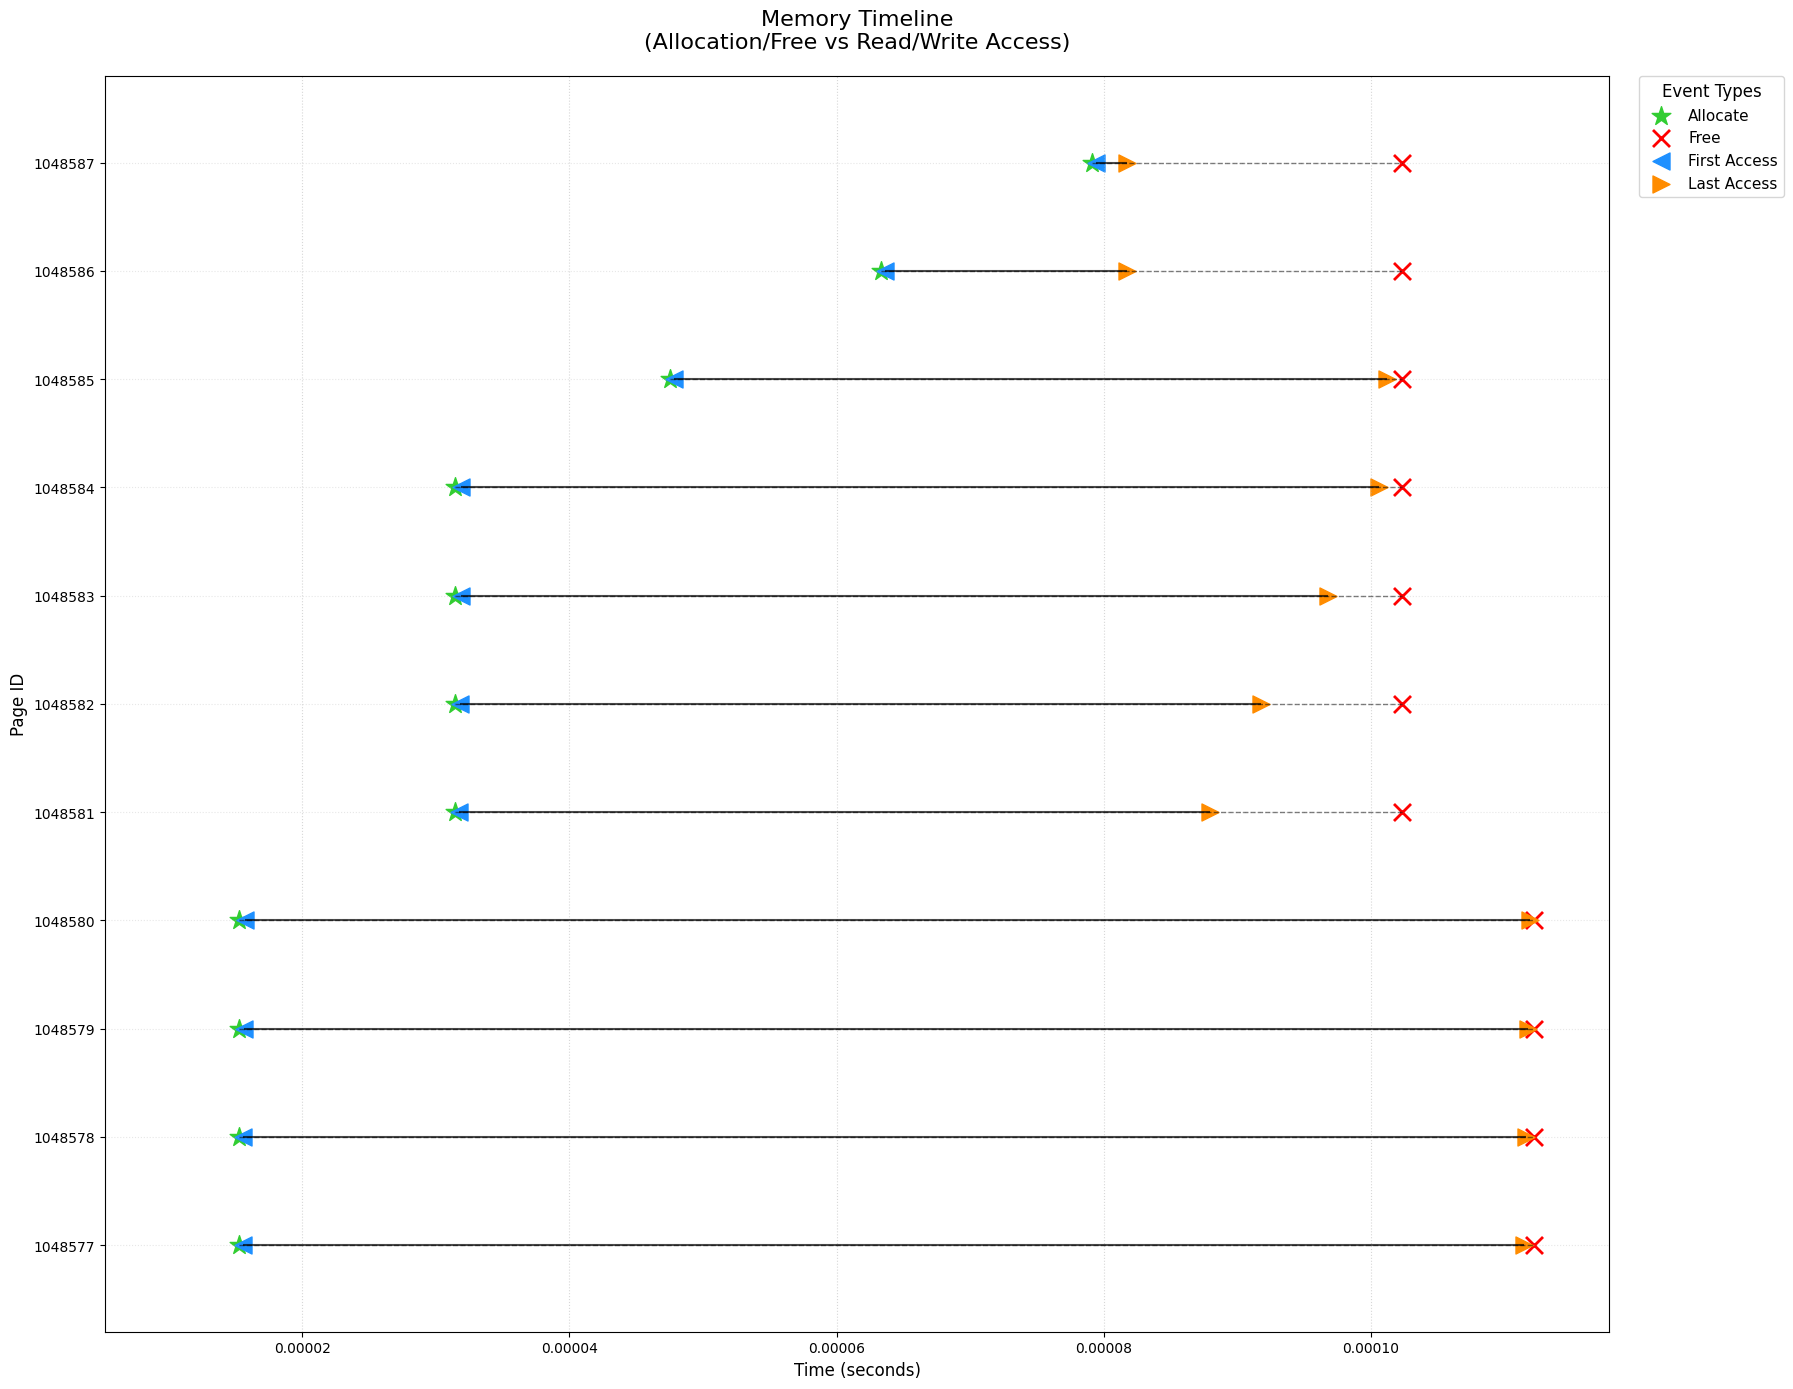

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 14))

# 创建统一的y轴映射
all_pages = sorted(set(page_rw_stats_df['PageID']).union(set(page_af_stats_df['PageID'])))
y_pos_map = {page: i for i, page in enumerate(all_pages)}

# 绘制分配/释放时间线
for _, row in page_af_stats_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    plt.scatter(row['AllocateTime'], y_pos,
               color='limegreen', marker='*', s=200,
               label='Allocate' if _ == 0 else '')
    plt.scatter(row['FreeTime'], y_pos,
               color='red', marker='x', s=150, linewidth=2,
               label='Free' if _ == 0 else '')
    plt.hlines(y=y_pos,
              xmin=row['AllocateTime'],
              xmax=row['FreeTime'],
              colors='black', linestyles='dashed', alpha=0.5, linewidth=1) # limegreen

# 绘制读写访问时间线
for _, row in page_rw_stats_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    plt.scatter(row['FirstAccessTime'], y_pos,
               color='dodgerblue', marker='<', s=150,
               label='First Access' if _ == 0 else '')
    plt.scatter(row['LastAccessTime'], y_pos,
               color='darkorange', marker='>', s=150,
               label='Last Access' if _ == 0 else '')
    plt.hlines(y=y_pos,
              xmin=row['FirstAccessTime'],
              xmax=row['LastAccessTime'],
              colors='black', alpha=0.7, linewidth=1.5)

# 设置坐标轴
plt.yticks(range(len(all_pages)), all_pages, fontsize=10)
plt.xticks(fontsize=10)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Page ID', fontsize=12)
plt.title('Memory Timeline\n(Allocation/Free vs Read/Write Access)', fontsize=16, pad=20)

# 调整坐标轴范围
min_time = min(page_af_stats_df['AllocateTime'].min(), page_rw_stats_df['FirstAccessTime'].min())
max_time = max(page_af_stats_df['FreeTime'].max(), page_rw_stats_df['LastAccessTime'].max())
plt.xlim(left=min_time-0.00001, right=max_time*1.05)
plt.ylim(bottom=-0.8, top=len(all_pages)-0.2)

# 添加网格线
plt.grid(True, axis='x', linestyle=':', alpha=0.5)
plt.grid(True, axis='y', linestyle=':', alpha=0.3)

# 将图例移到图表右侧外部
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),
          bbox_to_anchor=(1.02, 1),  # 将图例放在图表右侧外部
          loc='upper left',          # 锚点在左上角
          borderaxespad=0.,          # 与坐标轴的距离
          frameon=True,              # 显示边框
          fontsize=11,               # 增大字体
          title='Event Types',       # 添加图例标题
          title_fontsize=12)         # 图例标题大小

# 调整布局，为图例留出空间
plt.subplots_adjust(right=0.85)  # 为图例留出15%的右侧空间

plt.tight_layout()
timeline_path = os.path.join(results_dir, 'memory_timeline.png')
plt.savefig(timeline_path, dpi=300, bbox_inches='tight')
plt.show()


#### 6. 计算实际活跃率

In [88]:
# 合并两个DataFrame
page_stats_df = pd.merge(
    page_rw_stats_df[['PageID', 'FirstAccessTime', 'LastAccessTime', 'ActualLifeDuration']],
    page_af_stats_df[['PageID', 'AllocateTime', 'FreeTime', 'LifeDuration']],
    on='PageID',
    how='outer'  # 保留所有页面，即使只有一种统计
)

# 计算使用率比率
page_stats_df['UsageRatio'] = page_stats_df['ActualLifeDuration'] / page_stats_df['LifeDuration']

# 填充可能存在的NaN值（当LifeDuration为0时）
page_stats_df['UsageRatio'] = page_stats_df['UsageRatio'].fillna(0)

# 计算总持续时间
total_stats = {
    'TotalAllocatedTime': page_stats_df['LifeDuration'].sum(),
    'TotalActiveTime': page_stats_df['ActualLifeDuration'].sum(),
    'OverallUsageRatio': page_stats_df['ActualLifeDuration'].sum() / page_stats_df['LifeDuration'].sum()
}

print("page_stats_df:")
print(page_stats_df)
print(total_stats)

print("\n实际活跃率 = 实际生命周期 / 生命周期 * 100 = ", total_stats['OverallUsageRatio'] * 100, "%")

page_stats_df:
     PageID  FirstAccessTime  LastAccessTime  ActualLifeDuration  \
0   1048577         0.000016        0.000111            0.000096   
1   1048578         0.000016        0.000112            0.000096   
2   1048579         0.000016        0.000112            0.000096   
3   1048580         0.000016        0.000112            0.000096   
4   1048581         0.000032        0.000088            0.000056   
5   1048582         0.000032        0.000092            0.000060   
6   1048583         0.000032        0.000097            0.000065   
7   1048584         0.000032        0.000101            0.000069   
8   1048585         0.000048        0.000101            0.000053   
9   1048586         0.000064        0.000082            0.000018   
10  1048587         0.000079        0.000082            0.000002   

    AllocateTime  FreeTime  LifeDuration  UsageRatio  
0       0.000015  0.000112      0.000097    0.989205  
1       0.000015  0.000112      0.000097    0.990102  
2  

#### 7. 绘制生命周期时间线+内存访问图

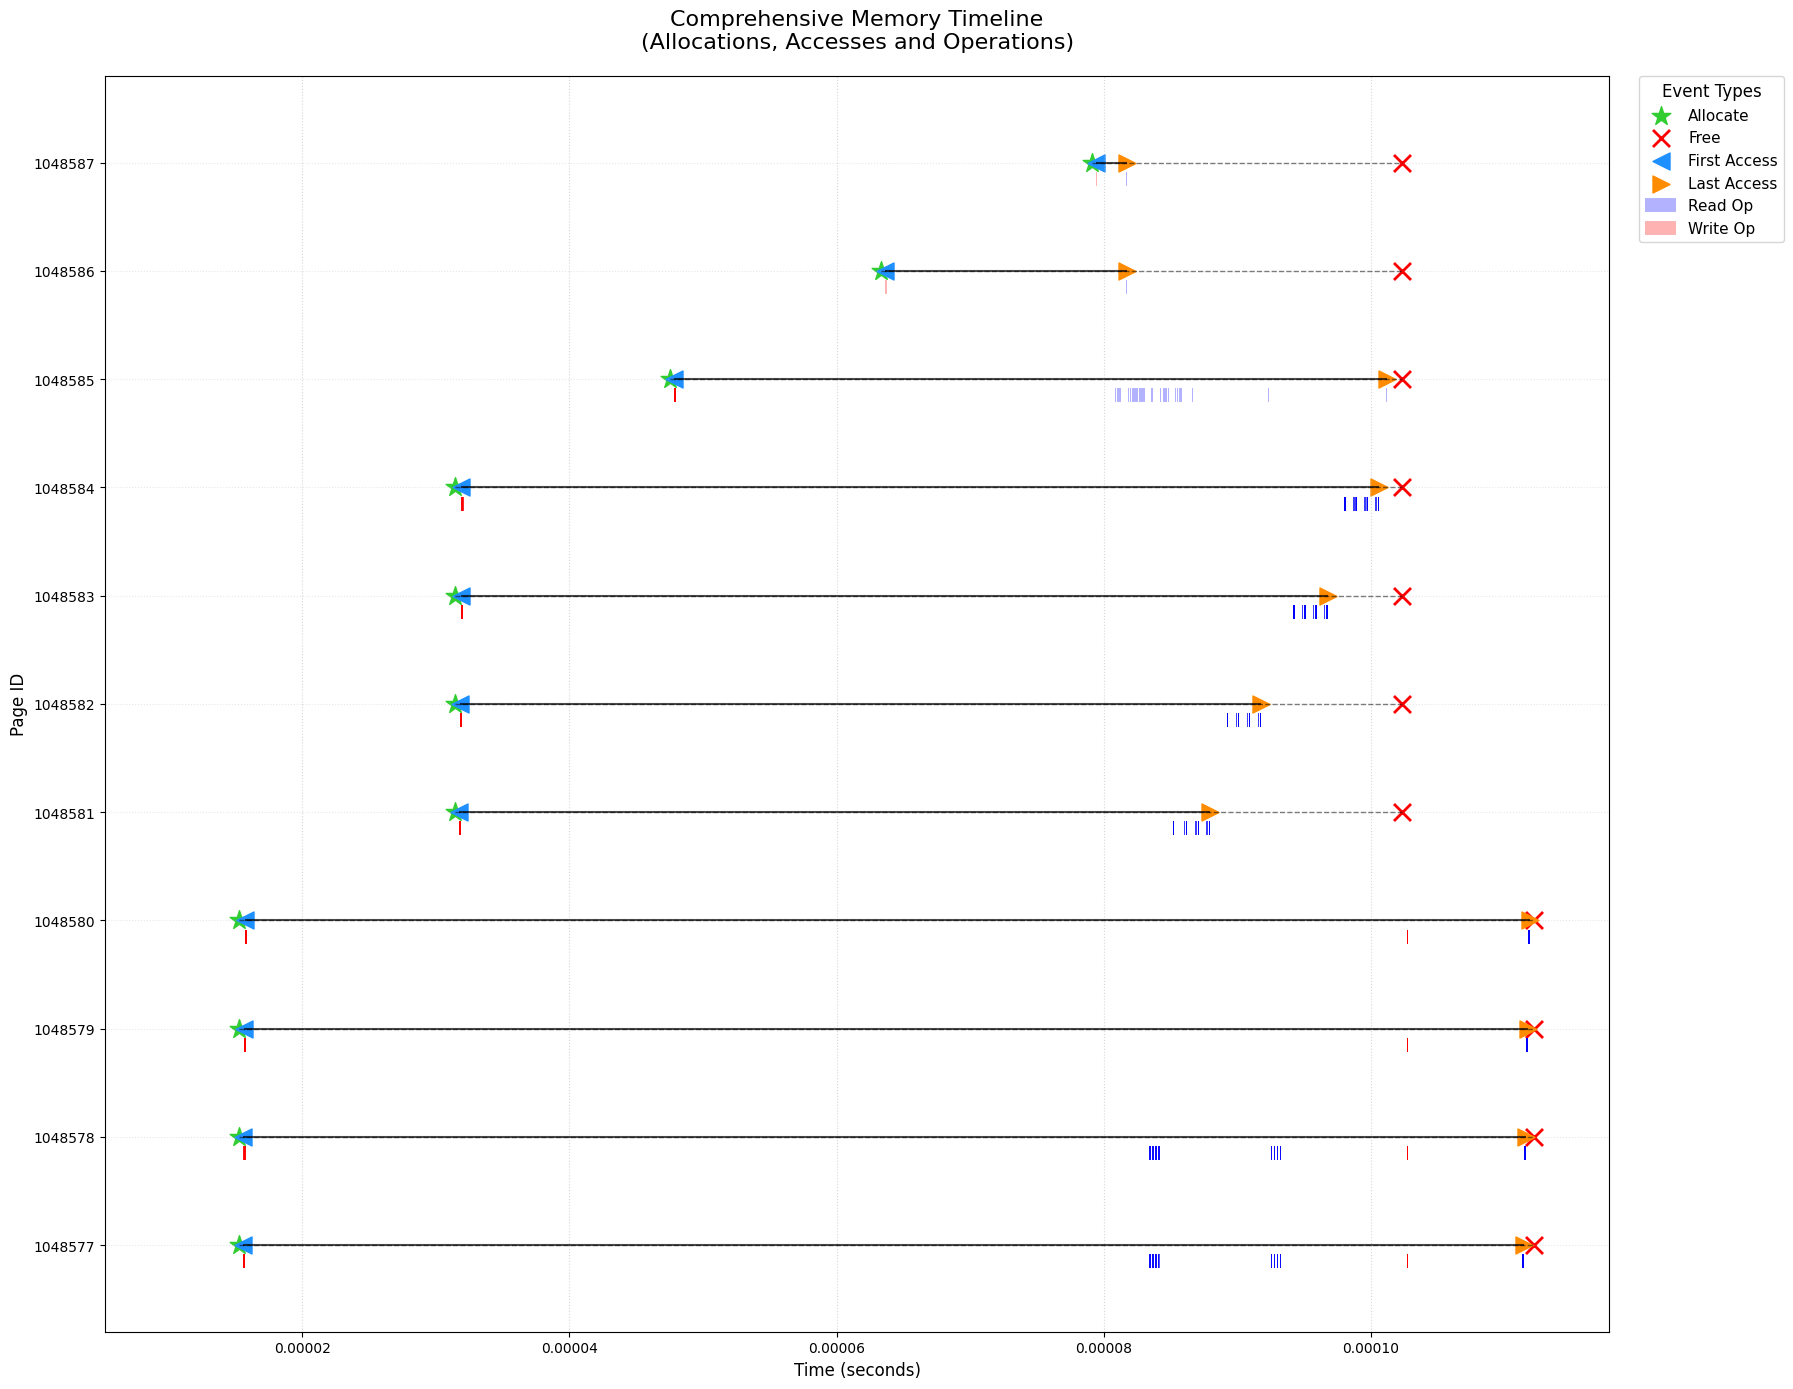

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 14))

# 创建统一的y轴映射（包含所有数据集的PageID）
all_pages = sorted(set(page_rw_stats_df['PageID'])
                  .union(set(page_af_stats_df['PageID']))
                  .union(set(rw_df['PageID'])))
y_pos_map = {page: i for i, page in enumerate(all_pages)}

# ===== 1. 绘制分配/释放时间线 =====
for _, row in page_af_stats_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    plt.scatter(row['AllocateTime'], y_pos,
               color='limegreen', marker='*', s=200,
               label='Allocate' if _ == 0 else '')
    plt.scatter(row['FreeTime'], y_pos,
               color='red', marker='x', s=150, linewidth=2,
               label='Free' if _ == 0 else '')
    plt.hlines(y=y_pos,
              xmin=row['AllocateTime'],
              xmax=row['FreeTime'],
              colors='black', linestyles='dashed', alpha=0.5, linewidth=1)

# ===== 2. 绘制首次/末次访问时间线 =====
for _, row in page_rw_stats_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    plt.scatter(row['FirstAccessTime'], y_pos,
               color='dodgerblue', marker='<', s=150,
               label='First Access' if _ == 0 else '')
    plt.scatter(row['LastAccessTime'], y_pos,
               color='darkorange', marker='>', s=150,
               label='Last Access' if _ == 0 else '')
    plt.hlines(y=y_pos,
              xmin=row['FirstAccessTime'],
              xmax=row['LastAccessTime'],
              colors='black', alpha=0.7, linewidth=1.5)

# ===== 3. 绘制详细的读写操作时间线 =====
for _, row in rw_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    
    # 根据访问类型设置样式
    if row['AccessType'] == '*mem.ReadReq':
        color = 'blue'
        line_alpha = 0.3
        label = 'Read Op' if _ == 0 or 'Read Op' not in plt.gca().get_legend_handles_labels()[1] else ''
    else:
        color = 'red'
        line_alpha = 0.3
        label = 'Write Op' if _ == 0 or 'Write Op' not in plt.gca().get_legend_handles_labels()[1] else ''
    
    # 绘制操作持续时间（横线）
    plt.hlines(y=y_pos - 0.15,
              xmin=row['StartTime'],
              xmax=row['EndTime'],
              colors=color,
              alpha=line_alpha,
              linewidth=10,
              label=label)
    
    # # 在操作开始处添加小标记
    # marker = '|' if row['AccessType'] == '*mem.ReadReq' else 'x'
    # plt.scatter(row['StartTime'], y_pos,
    #            color=color, marker=marker, s=50, alpha=0.8)

# ===== 图表装饰 =====
# 设置坐标轴
plt.yticks(range(len(all_pages)), all_pages, fontsize=10)
plt.xticks(fontsize=10)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Page ID', fontsize=12)
plt.title('Comprehensive Memory Timeline\n(Allocations, Accesses and Operations)', 
         fontsize=16, pad=20)

# 调整坐标轴范围
min_time = min(page_af_stats_df['AllocateTime'].min(), 
               page_rw_stats_df['FirstAccessTime'].min(),
               rw_df['StartTime'].min())
max_time = max(page_af_stats_df['FreeTime'].max(), 
              page_rw_stats_df['LastAccessTime'].max(),
              rw_df['EndTime'].max())
plt.xlim(left=min_time-0.00001, right=max_time*1.05)
plt.ylim(bottom=-0.8, top=len(all_pages)-0.2)

# 添加网格线
plt.grid(True, axis='x', linestyle=':', alpha=0.5)
plt.grid(True, axis='y', linestyle=':', alpha=0.3)

# 合并图例
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = {}
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels[label] = handle

# 按类别排序图例（分配/访问/操作）
legend_order = ['Allocate', 'Free', 'First Access', 'Last Access', 'Read Op', 'Write Op']
sorted_handles = [unique_labels[label] for label in legend_order if label in unique_labels]
sorted_labels = [label for label in legend_order if label in unique_labels]

plt.legend(sorted_handles, sorted_labels,
          bbox_to_anchor=(1.02, 1),
          loc='upper left',
          borderaxespad=0.,
          frameon=True,
          fontsize=11,
          title='Event Types',
          title_fontsize=12)

# 调整布局
plt.subplots_adjust(right=0.85)
plt.tight_layout()

timeline_access_path = os.path.join(results_dir, 'memory_timeline_access.png')
plt.savefig(timeline_access_path, dpi=300, bbox_inches='tight')
plt.show()

#### 8. 绘制内存访问图

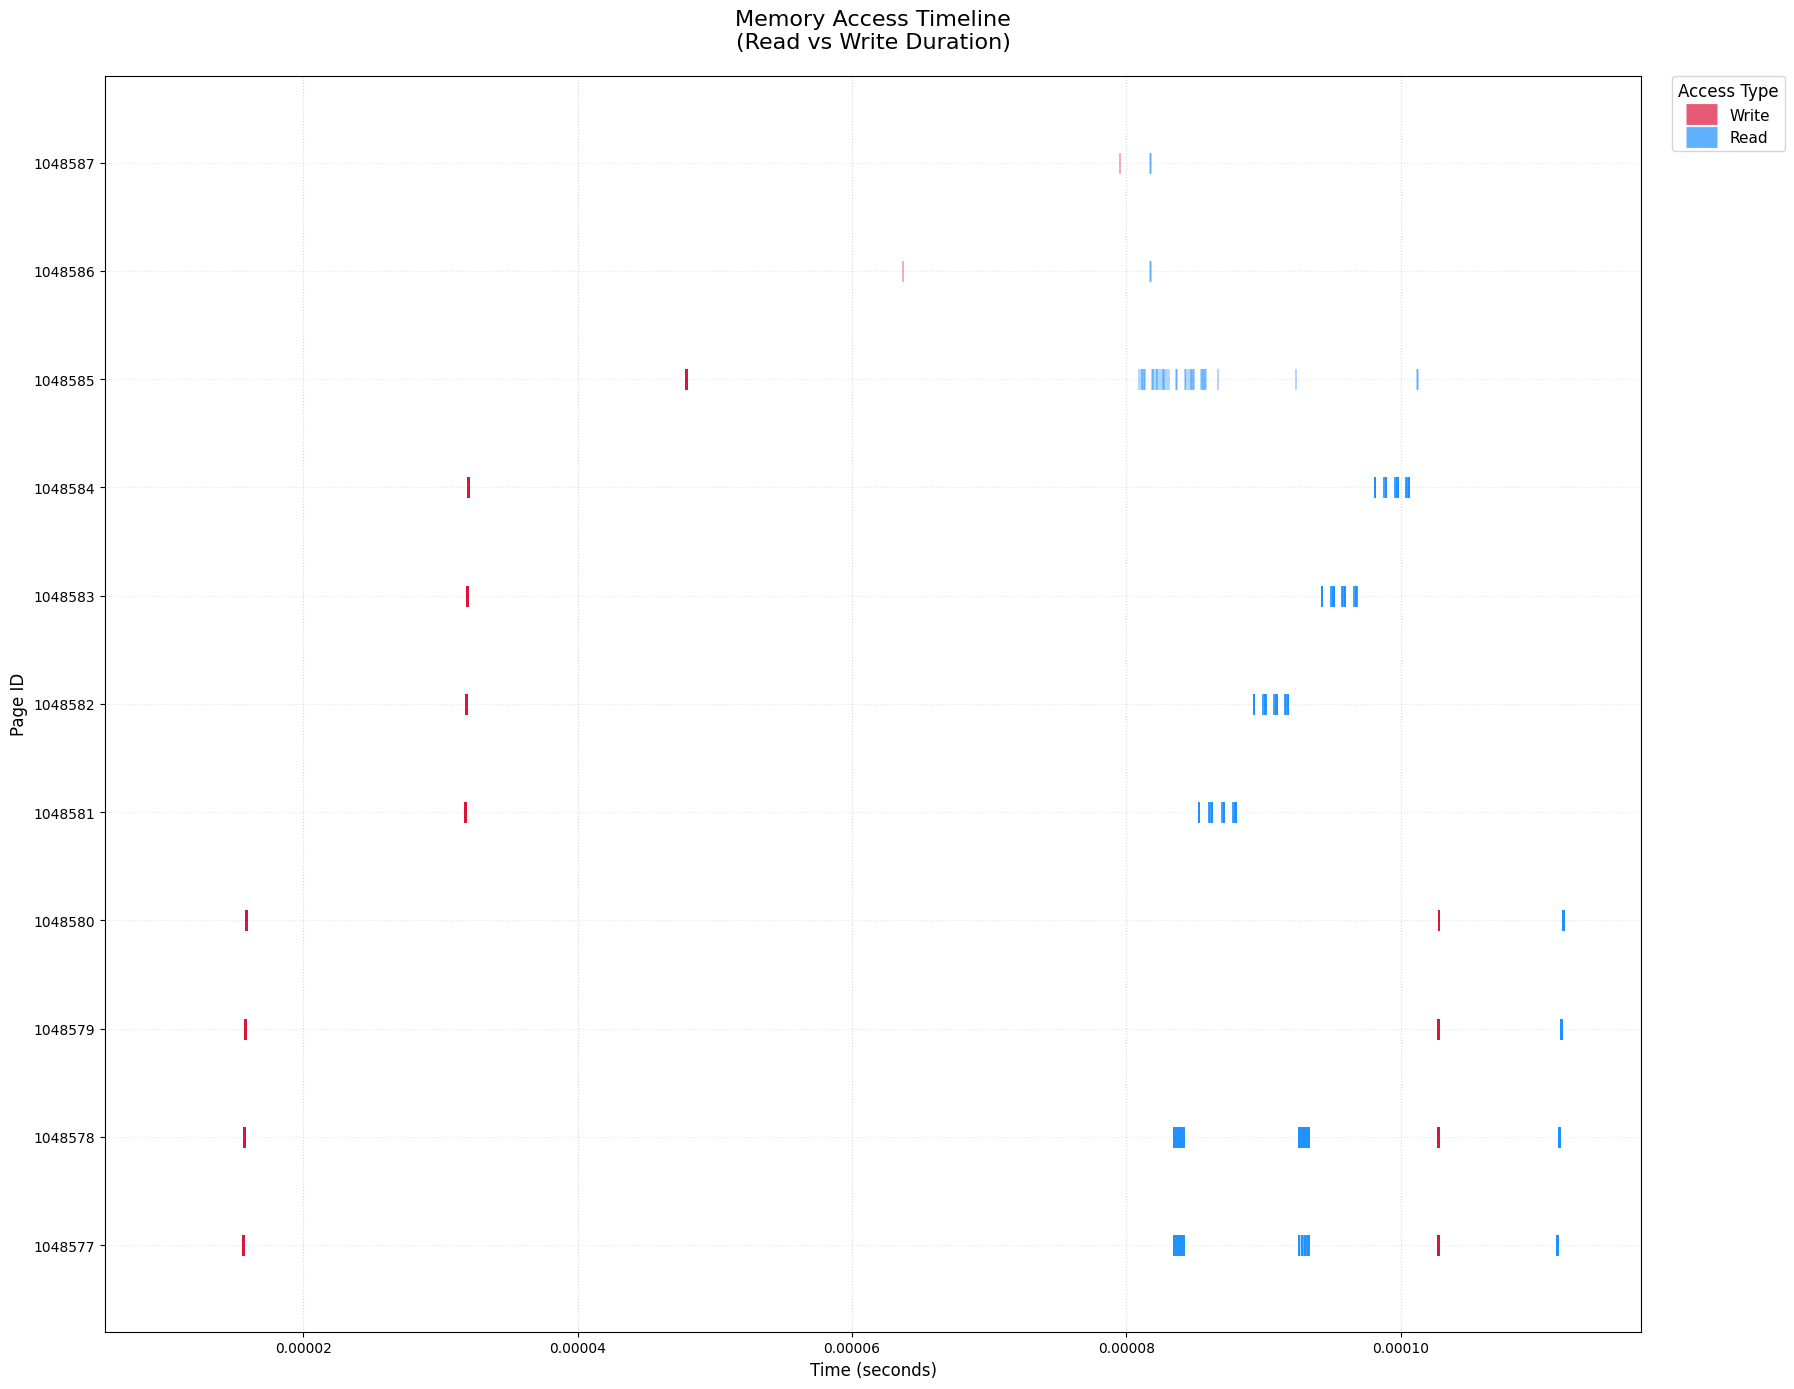

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 14))

# 创建统一的 y 轴映射（仅基于 rw_df 的 PageID）
all_pages = sorted(rw_df['PageID'].unique())
y_pos_map = {page: i for i, page in enumerate(all_pages)}

# 绘制每个读写访问的持续时间（横线）
for _, row in rw_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    
    # 根据访问类型选择颜色和样式
    if row['AccessType'] == '*mem.ReadReq':
        color = 'dodgerblue'
        linestyle = '-'  # 实线表示读
        label = 'Read' if _ == 0 or 'Read' not in plt.gca().get_legend_handles_labels()[1] else ''
    else:  # '*mem.WriteReq'
        color = 'crimson'
        linestyle = '--'  # 虚线表示写
        label = 'Write' if _ == 0 or 'Write' not in plt.gca().get_legend_handles_labels()[1] else ''
    
    # 绘制横线（连接 StartTime 和 EndTime）
    plt.hlines(
        y=y_pos,
        xmin=row['StartTime'],
        xmax=row['EndTime'],
        colors=color,
        linestyles=linestyle,
        alpha=0.7,
        linewidth=15,
        label=label
    )
    
    # 可选：在访问的起点和终点添加标记
    # plt.scatter(
    #     row['StartTime'], y_pos,
    #     color=color,
    #     marker='>',  # 右箭头表示开始
    #     s=50,
    #     alpha=0.9,
    #     label=''  # 不重复添加图例
    # )
    # plt.scatter(
    #     row['EndTime'], y_pos,
    #     color=color,
    #     marker='<',  # 左箭头表示结束
    #     s=50,
    #     alpha=0.9,
    #     label=''
    # )

# 设置坐标轴
plt.yticks(range(len(all_pages)), all_pages, fontsize=10)
plt.xticks(fontsize=10)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Page ID', fontsize=12)
plt.title('Memory Access Timeline\n(Read vs Write Duration)', fontsize=16, pad=20)

# 调整坐标轴范围
min_time = rw_df['StartTime'].min()
max_time = rw_df['EndTime'].max()
plt.xlim(left=min_time - 0.00001, right=max_time * 1.05)
plt.ylim(bottom=-0.8, top=len(all_pages) - 0.2)

# 添加网格线
plt.grid(True, axis='x', linestyle=':', alpha=0.5)
plt.grid(True, axis='y', linestyle=':', alpha=0.3)

# 自定义图例（避免重复）
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # 去重
plt.legend(
    unique_labels.values(),
    unique_labels.keys(),
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    frameon=True,
    fontsize=11,
    title='Access Type',
    title_fontsize=12
)

# 调整布局
plt.subplots_adjust(right=0.85)
plt.tight_layout()
plt.show()